 ## Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report
import sys

In [2]:
print(f"Python version -> {sys.version}")  # 3.12.3
print(f"torch version -> {torch.__version__}")  # 2.8.0+cu128

Python version -> 3.13.3 (tags/v3.13.3:6280bb5, Apr  8 2025, 14:47:33) [MSC v.1943 64 bit (AMD64)]
torch version -> 2.9.1+cpu


 ## Importing Data

In [3]:
transform = transforms.Compose([transforms.ToTensor()])  # converts [0,255] → [0,1]

train_dataset = datasets.MNIST(
    root="../data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="../data", train=False, download=True, transform=transform
)

x_train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
x_test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples : {len(test_dataset)}")

Train samples: 60000
Test samples : 10000


transorm

 ## Data Normalization

In [4]:
# Note: torchvision.transforms.ToTensor() already normalizes to [0,1]
example_data, example_target = next(iter(x_train_loader))
print(f"Example batch shape: {example_data.shape}")

Example batch shape: torch.Size([512, 1, 28, 28])


 ### Some examples

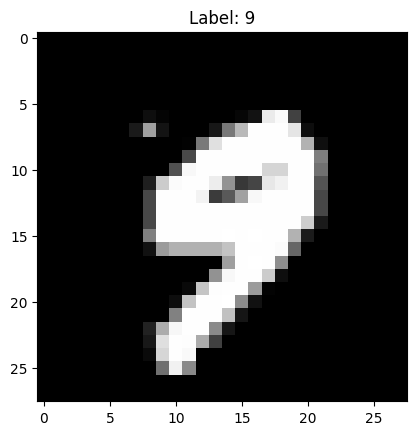

In [5]:
plt.imshow(example_data[8][0], cmap="gray")
plt.title(f"Label: {example_target[8].item()}")
plt.show()

 ## Building model

In [6]:
hidden1 = 16
hidden2 = 16


class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPModel().to(device)
print(model)

MLPModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


 ## Train the model

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 512
epochs = 16

train_accs, val_accs = [], []
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in x_train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc = correct / total
    train_loss = running_loss / len(x_train_loader)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for images, labels in x_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(x_test_loader))
    val_accs.append(val_acc)

    if (epoch + 1) % 2 == 0 or epoch == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}] Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}% | Val_Loss: {val_losses[-1]:.4f}, Val_Acc: {val_acc*100:.2f}%"
        )

print("Training complete!")

Epoch [1/16] Loss: 1.3778, Acc: 61.29% | Val_Loss: 0.6345, Val_Acc: 82.96%
Epoch [2/16] Loss: 0.4933, Acc: 86.21% | Val_Loss: 0.3897, Val_Acc: 89.40%
Epoch [4/16] Loss: 0.3078, Acc: 91.32% | Val_Loss: 0.2896, Val_Acc: 91.93%
Epoch [6/16] Loss: 0.2610, Acc: 92.73% | Val_Loss: 0.2557, Val_Acc: 92.91%
Epoch [8/16] Loss: 0.2321, Acc: 93.46% | Val_Loss: 0.2385, Val_Acc: 93.25%
Epoch [10/16] Loss: 0.2141, Acc: 93.95% | Val_Loss: 0.2225, Val_Acc: 93.84%
Epoch [12/16] Loss: 0.2007, Acc: 94.27% | Val_Loss: 0.2146, Val_Acc: 93.96%
Epoch [14/16] Loss: 0.1909, Acc: 94.58% | Val_Loss: 0.2038, Val_Acc: 94.27%
Epoch [16/16] Loss: 0.1806, Acc: 94.85% | Val_Loss: 0.1968, Val_Acc: 94.60%
Training complete!


 ## Evaluation of the model

In [8]:
model.eval()
correct, total = 0, 0
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in x_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test accuracy : {test_accuracy:.4f}")

Test accuracy : 0.9460


 ## Plot history

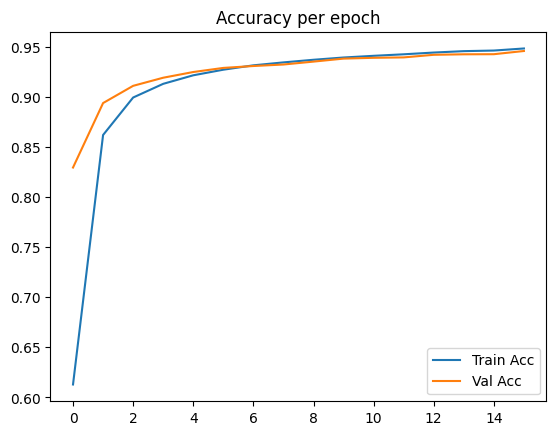

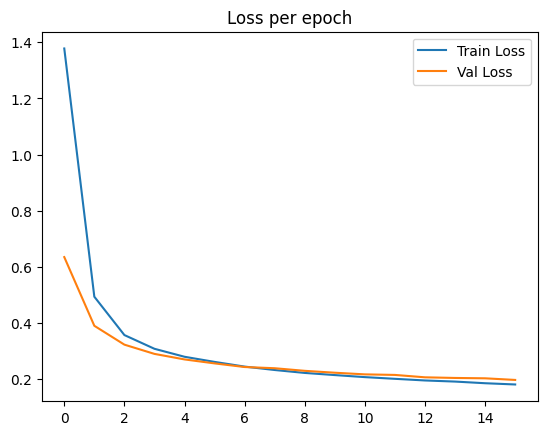

In [9]:
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy per epoch")
plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss per epoch")
plt.show()

 ## Performance Analysis

In [10]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 962    0    1    1    1    3    4    3    4    1]
 [   0 1114    4    2    0    1    3    1    9    1]
 [   7    2  967   14   11    1   11    6   11    2]
 [   2    1   14  943    3   13    0   11   18    5]
 [   0    2    7    1  933    0    4    3    7   25]
 [   6    2    1   28    4  816   14    2   15    4]
 [   9    2    7    1    2   14  918    1    4    0]
 [   1    6   20    2    2    1    0  983    3   10]
 [   5    7    7   23    7   10    8   16  886    5]
 [   9    7    2   10   23    4    0   12    4  938]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.94      0.94      0.94      1032
           3       0.92      0.93      0.93      1010
           4       0.95      0.95      0.95       982
           5       0.95      0.91      0.93       892
           6       0.95      0.96      0.96       958
           7       0.95      0.96   

In [11]:
errors = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
print("Number of errors:", len(errors))

Number of errors: 540
